# Forecasting with different solutions

We wil review the following options:

* SARIMA Model using Auto Arima
* Recurrent Neural Nets
* Convolutional Neural Nets
* Facebook's Prophet Library

The goal is to compare and find which one serves the best forecast and write a short article on each.

## Data Prep and Exploration 
*Note different model approaches might require a different data prep

In [45]:
install_dependencies = False
if install_dependencies:
    !pip install plotly==4.12.0
    !pip install pmdarima
    !pip install pystan
    !pip install fbprophet

In [113]:
#Import Data and Viz Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

#Stats Library
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Evaluation metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

#Facebook Prophet Libraries
from fbprophet import Prophet

#Tensorflow library
import tensorflow as tf

In [47]:
#Clean the currency column to make it a float
#The Revenue column is a string so we need to convert to floatdef clean_currency(x):
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('£', '').replace(',', ''))
    return(x)

In [48]:
df = pd.read_csv("data/boohooman_20200701_20201031.csv")
df.head()

,Date,Revenue
0,20200701,"£310,125.53"
1,20200702,"£267,367.19"
2,20200703,"£259,462.99"
3,20200704,"£225,009.43"
4,20200705,"£256,431.46"


In [49]:
#Convert Date column to timestamp
df.set_index('Date',inplace=True)
df.head()

,Revenue
Date,
20200701,"£310,125.53"
20200702,"£267,367.19"
20200703,"£259,462.99"
20200704,"£225,009.43"
20200705,"£256,431.46"


In [50]:
df.index = pd.to_datetime(df.index,format="%Y%m%d")
df.head()

,Revenue
Date,
2020-07-01,"£310,125.53"
2020-07-02,"£267,367.19"
2020-07-03,"£259,462.99"
2020-07-04,"£225,009.43"
2020-07-05,"£256,431.46"


In [51]:
#Convert Revenue column to Float
df["Revenue"] = df['Revenue'].apply(clean_currency).astype('float')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2020-07-01 to 2020-10-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  123 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


## Data Visualization

### Line plot

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




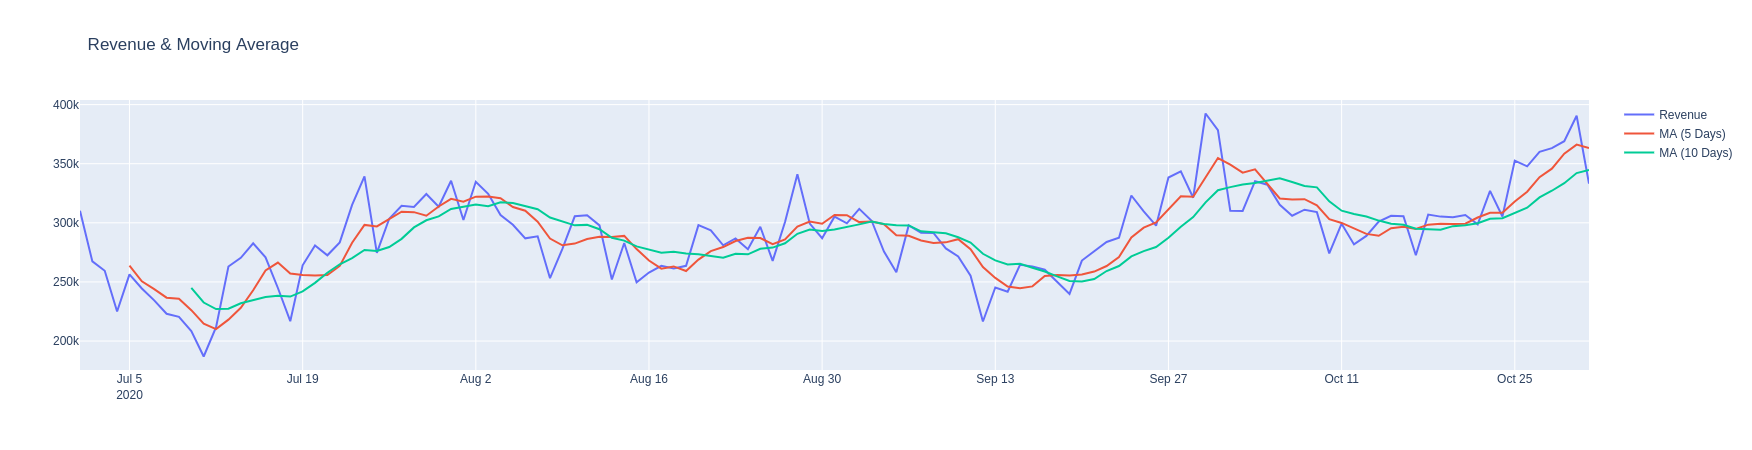

In [53]:
#fig = px.line(df,x=df.index,y=["Revenue",df.Revenue.rolling(10).mean()],title="Time Series Revenue Range")
fig = go.Figure()
fig.add_trace(go.Line(x=df.index,y=df["Revenue"],name="Revenue"))
fig.add_trace(go.Line(x=df.index,y=df.Revenue.rolling(5).mean(),name="MA (5 Days)"))
fig.add_trace(go.Line(x=df.index,y=df.Revenue.rolling(10).mean(),name="MA (10 Days)"))
fig.update_layout(title="Revenue & Moving Average")
fig.show()
#fig2 = px.line(df.Revenue.rolling(10).mean(),x=df.index,y="Revenue")

#fig2.show()

In [54]:
#Adding the day of the week to see if there are specific days when the revenue increase
df["week_day"] = list(pd.Series(df.index).dt.day_name())
df.head()

,Revenue,week_day
Date,,
2020-07-01,310125.53,Wednesday
2020-07-02,267367.19,Thursday
2020-07-03,259462.99,Friday
2020-07-04,225009.43,Saturday
2020-07-05,256431.46,Sunday


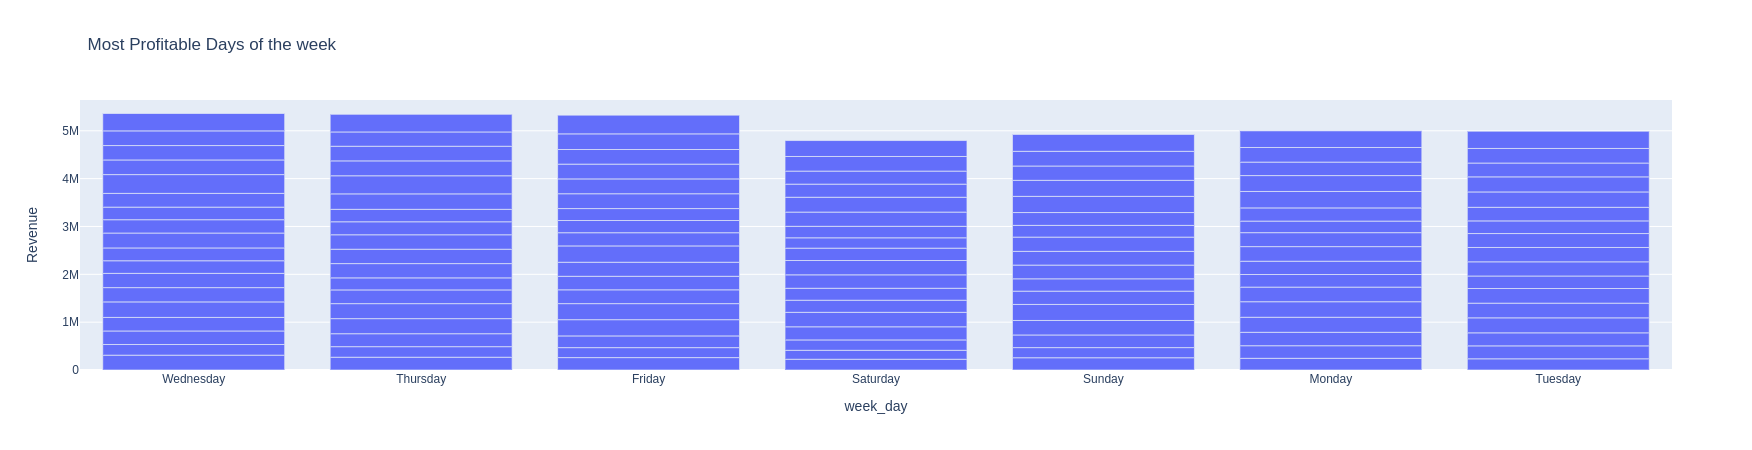

In [55]:
fig = px.bar(df,x="week_day",y="Revenue",title="Most Profitable Days of the week")
fig.show()

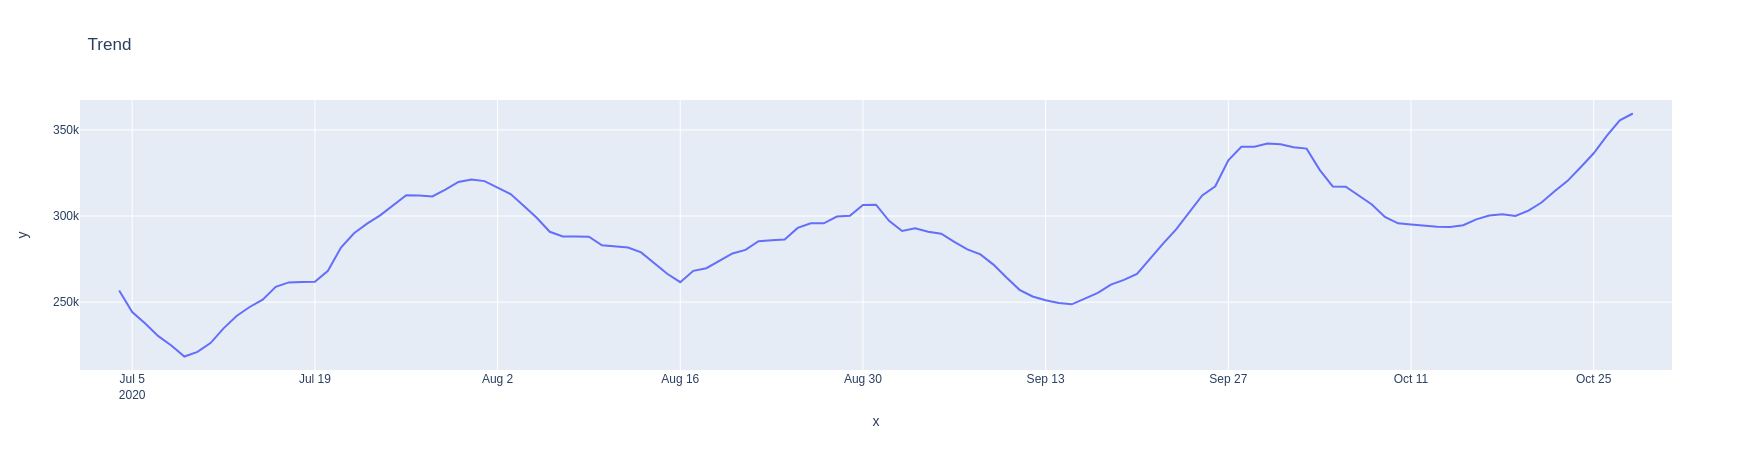

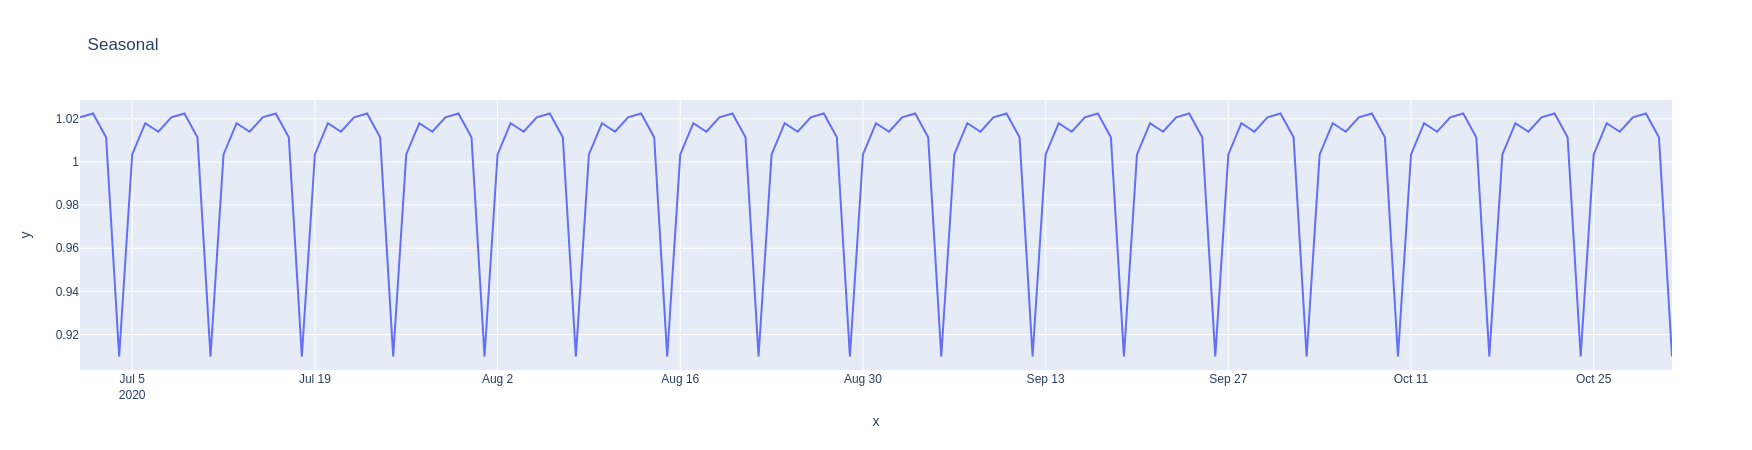

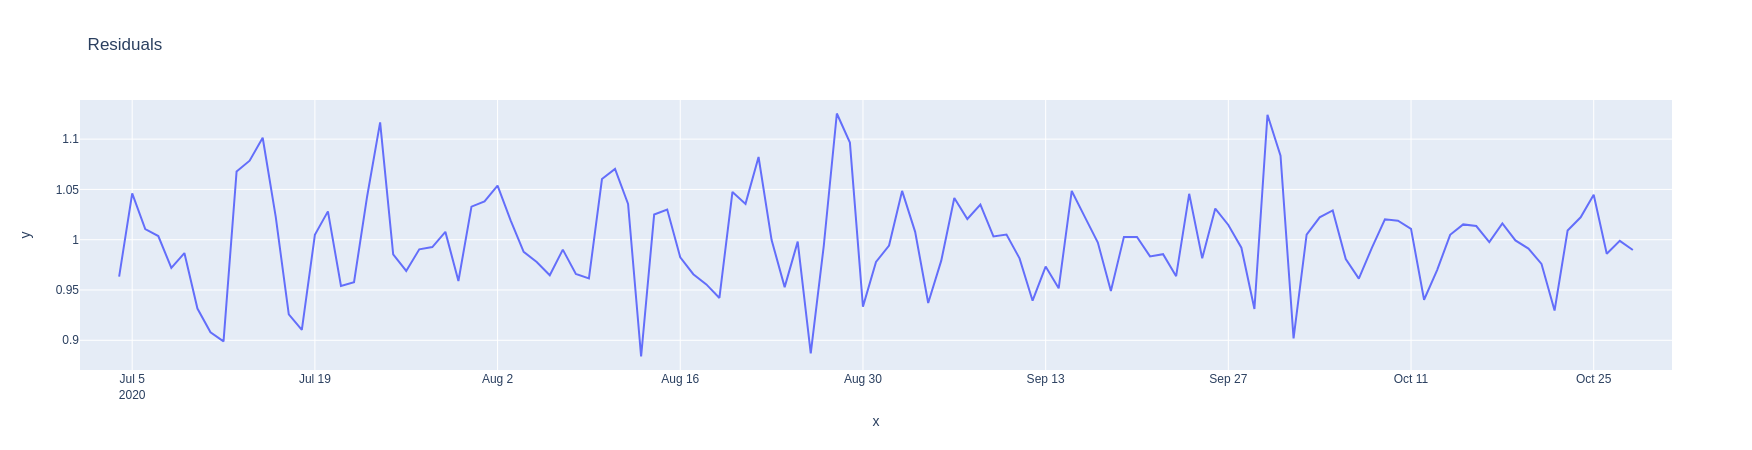

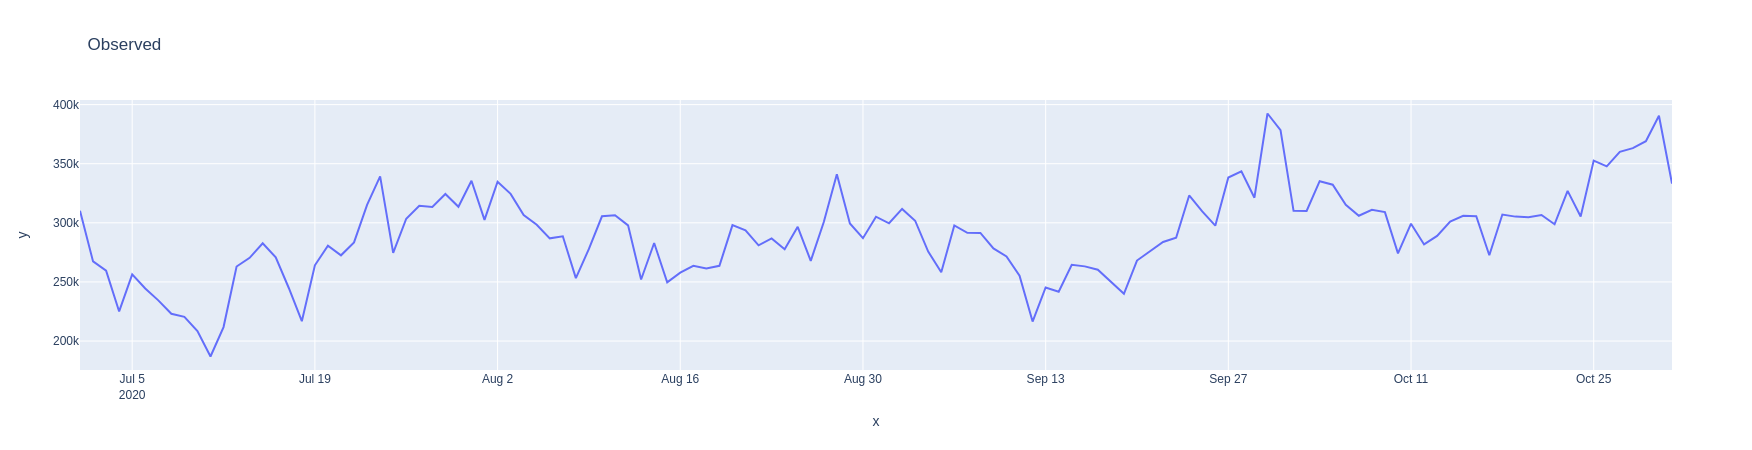

In [56]:
results = seasonal_decompose(df["Revenue"],model="mutliplicative")
fig1 = px.line(results.trend,x=df.index,y=results.trend, title="Trend")
fig2 = px.line(results.seasonal,x=df.index,y=results.seasonal, title="Seasonal")
fig3 = px.line(results.resid,x=df.index,y=results.resid, title="Residuals")
fig4 = px.line(results.observed,x=df.index,y=results.observed, title="Observed")
fig1.show()
fig2.show()
fig3.show()
fig4.show()

## SARIMA Model

This is a time series forecasting technique called *Seasonal Autoregressive Integrated Moving Average Exogenous*, it is similar to *Autogressive Inegrated Moving Average Exogenous* but it included another set of parameters for P,D, Q which are for seasonality. 

We can some from the *Seasonal* plot above that there is some seasonality. This means we might need to account for seasonality. Even in the *Observed* plot we see some seasonality but not a great deal. This means we will need to add some differencing to help idenitify seasonality. 

I am going to use the auto_arima library to determine the right values for PDQ.

In [57]:
auto_arima(df["Revenue"],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  123
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood               -1393.314
Date:                            Thu, 12 Nov 2020   AIC                           2796.628
Time:                                    21:07:04   BIC                           2810.648
Sample:                                         0   HQIC                          2802.322
                                            - 123                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4653      0.220      2.116      0.034       0.034       0.896
ma.L1         -0.6649      0.173     -3.841      0.000      -1.004      -0.326
ar.S.L7        0.0877      0.039      2.223      0.026       0.010       0.165
ar.S.L14       0.1263      0.078      1.612      0.107      -0.027       0.280
sigma2      5.195e+08   1.81e-10   2.86e+18      0.000     5.2e+08     5.2e+08
===================================================================================
Ljung-Box (Q):                       63.23   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.01   Prob(JB):                         0.61
Heteroskedasticity (H):               1.06   Skew:                             0.11
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.22e+33. Standard errors may be unstable.
"""

In [58]:
#Split the dataset
sarima_train = df.iloc[:90]
sarima_test = df.iloc[90:]

In [59]:
sarima_model = SARIMAX(sarima_train["Revenue"],order=(1,1,1),seasonal_order=(2,0,0,7))
sarima_results = sarima_model.fit()
sarima_results.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood               -1013.186
Date:                            Thu, 12 Nov 2020   AIC                           2036.372
Time:                                    21:07:04   BIC                           2048.815
Sample:                                07-01-2020   HQIC                          2041.388
                                     - 09-28-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5523      0.262      2.105      0.035       0.038       1.067
ma.L1         -0.7201      0.209     -3.453      0.001      -1.129      -0.311
ar.S.L7        0.0666      0.047      1.428      0.153      -0.025       0.158
ar.S.L14       0.1143      0.080      1.434      0.152      -0.042       0.271
sigma2      4.825e+08      2e-10   2.41e+18      0.000    4.83e+08    4.83e+08
===================================================================================
Ljung-Box (Q):                       69.99   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.00   Prob(JB):                         0.73
Heteroskedasticity (H):               0.60   Skew:                             0.12
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.44e+34. Standard errors may be unstable.
"""

In [60]:
#Getting start and end dates fro model
start = len(sarima_train)
end = start + len(sarima_test) - 1

In [61]:
sarima_predictions = sarima_results.predict(start=start,end=end,typ="levels").rename("SARIMA(1,1,1)")

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




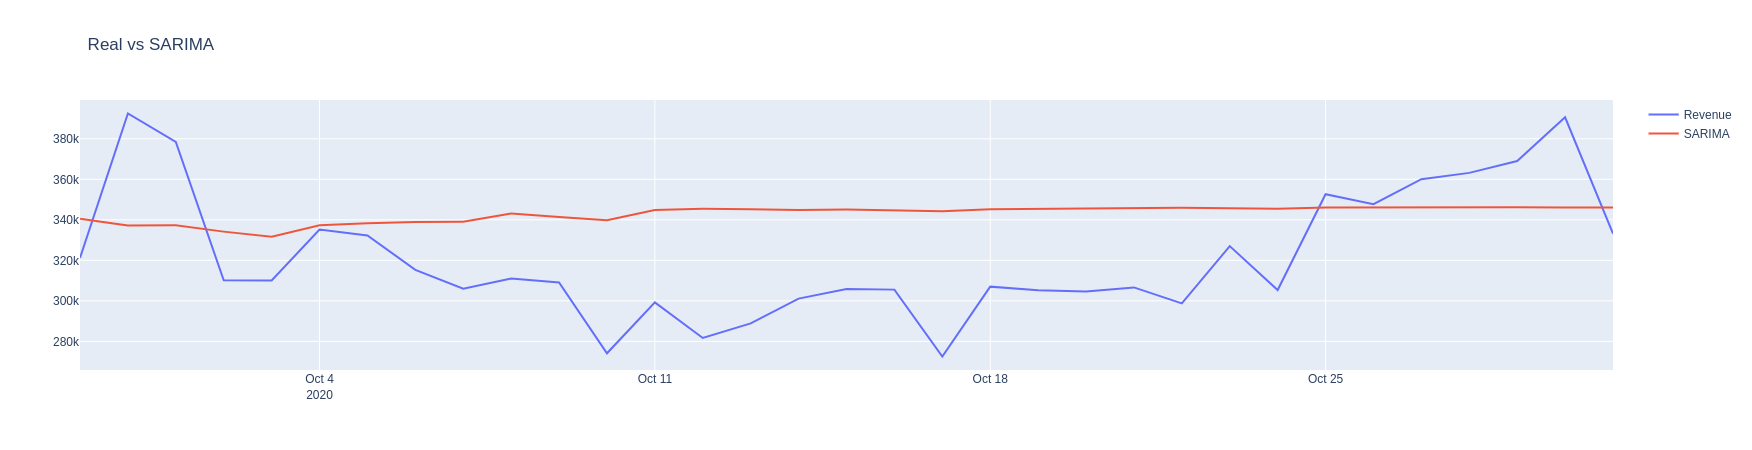

In [62]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=sarima_predictions.index,y=sarima_predictions,name="SARIMA"))
fig.update_layout(title="Real vs SARIMA")
fig.show()

## Facebook's Prophet Library

This is a open source library from Facebook which is a procedure for time series forecasting on additive model where there are non-linear trends.

It is meant to be fast, accurate, automated and tunable to your data.

Facebook's prophets requires specifics values for the columns and only two columns Datetime & Target Variable.

In [63]:
#Removing the weekend day column
df_fb = df.copy()
df_fb.drop(columns="week_day",axis=1,inplace=True)
df_fb.head()

,Revenue
Date,
2020-07-01,310125.53
2020-07-02,267367.19
2020-07-03,259462.99
2020-07-04,225009.43
2020-07-05,256431.46


In [64]:
#Converting date index back into date
df_fb["ds"] = df.index
df_fb.head()

,Revenue,ds
Date,,
2020-07-01,310125.53,2020-07-01
2020-07-02,267367.19,2020-07-02
2020-07-03,259462.99,2020-07-03
2020-07-04,225009.43,2020-07-04
2020-07-05,256431.46,2020-07-05


In [65]:
df_fb.columns=["y","ds"]
df_fb.head()

,y,ds
Date,,
2020-07-01,310125.53,2020-07-01
2020-07-02,267367.19,2020-07-02
2020-07-03,259462.99,2020-07-03
2020-07-04,225009.43,2020-07-04
2020-07-05,256431.46,2020-07-05


In [66]:
df_fb.reset_index(inplace=True)

In [67]:
df_fb.drop(columns="Date",axis=1,inplace=True)
df_fb.head()

,y,ds
0,310125.53,2020-07-01
1,267367.19,2020-07-02
2,259462.99,2020-07-03
3,225009.43,2020-07-04
4,256431.46,2020-07-05


In [68]:
#Date column or ds needs to be a datetime object
df_fb["ds"] = pd.to_datetime(df_fb["ds"])
df_fb.head()

,y,ds
0,310125.53,2020-07-01
1,267367.19,2020-07-02
2,259462.99,2020-07-03
3,225009.43,2020-07-04
4,256431.46,2020-07-05


In [69]:
#Forecasting with no train test split
fb_model = Prophet()
fb_model.fit(df_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
#Forecast into the future
future = fb_model.make_future_dataframe(periods=30) #predicting 30 days into the future

In [71]:
future

,ds
0,2020-07-01
1,2020-07-02
2,2020-07-03
3,2020-07-04
4,2020-07-05
...,...
148,2020-11-26
149,2020-11-27
150,2020-11-28
151,2020-11-29


In [72]:
forecast = fb_model.predict(future)

In [73]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-01,259884.163223,228370.141429,305047.812452,259884.163223,259884.163223,7968.043607,7968.043607,7968.043607,7968.043607,7968.043607,7968.043607,0.0,0.0,0.0,267852.206831
1,2020-07-02,260353.553978,228988.588692,306887.079262,260353.553978,260353.553978,6485.030289,6485.030289,6485.030289,6485.030289,6485.030289,6485.030289,0.0,0.0,0.0,266838.584267
2,2020-07-03,260822.944733,225440.520804,306265.422176,260822.944733,260822.944733,4900.221182,4900.221182,4900.221182,4900.221182,4900.221182,4900.221182,0.0,0.0,0.0,265723.165916
3,2020-07-04,261292.335488,198334.114588,272813.228484,261292.335488,261292.335488,-25054.802543,-25054.802543,-25054.802543,-25054.802543,-25054.802543,-25054.802543,0.0,0.0,0.0,236237.532946
4,2020-07-05,261761.726243,220460.999469,299055.495141,261761.726243,261761.726243,-312.693985,-312.693985,-312.693985,-312.693985,-312.693985,-312.693985,0.0,0.0,0.0,261449.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2020-11-26,347139.416097,318054.092232,392481.891631,346560.831426,347726.284655,6485.030289,6485.030289,6485.030289,6485.030289,6485.030289,6485.030289,0.0,0.0,0.0,353624.446387
149,2020-11-27,347856.758232,316247.532218,389439.964683,347254.855462,348496.665721,4900.221182,4900.221182,4900.221182,4900.221182,4900.221182,4900.221182,0.0,0.0,0.0,352756.979414
150,2020-11-28,348574.100366,284965.731226,359805.151204,347940.638863,349258.833866,-25054.802543,-25054.802543,-25054.802543,-25054.802543,-25054.802543,-25054.802543,0.0,0.0,0.0,323519.297824
151,2020-11-29,349291.442501,308190.188020,385540.864788,348619.258970,350011.802862,-312.693985,-312.693985,-312.693985,-312.693985,-312.693985,-312.693985,0.0,0.0,0.0,348978.748516


In [74]:
forecast[['ds','yhat_lower','yhat_upper','yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2020-07-01,228370.141429,305047.812452,267852.206831
1,2020-07-02,228988.588692,306887.079262,266838.584267
2,2020-07-03,225440.520804,306265.422176,265723.165916
3,2020-07-04,198334.114588,272813.228484,236237.532946
4,2020-07-05,220460.999469,299055.495141,261449.032258
...,...,...,...,...
148,2020-11-26,318054.092232,392481.891631,353624.446387
149,2020-11-27,316247.532218,389439.964683,352756.979414
150,2020-11-28,284965.731226,359805.151204,323519.297824
151,2020-11-29,308190.188020,385540.864788,348978.748516


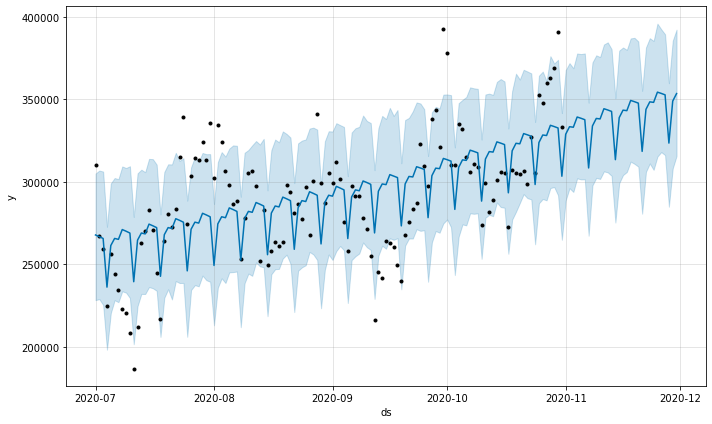

In [75]:
fb_model.plot(forecast); #At thist stage we are predicting until the end of the year but we want to  test

In [76]:
#Create prophets train and test  datasets
fb_train = df_fb.iloc[:90]
fb_test = df_fb.iloc[90:]

In [77]:
fb_prophet_model = Prophet(seasonality_mode="multiplicative",weekly_seasonality=True)
fb_prophet_model.fit(fb_train)
prophet_future = fb_prophet_model.make_future_dataframe(periods=33,freq="D")
prophet_forecast = fb_prophet_model.predict(prophet_future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




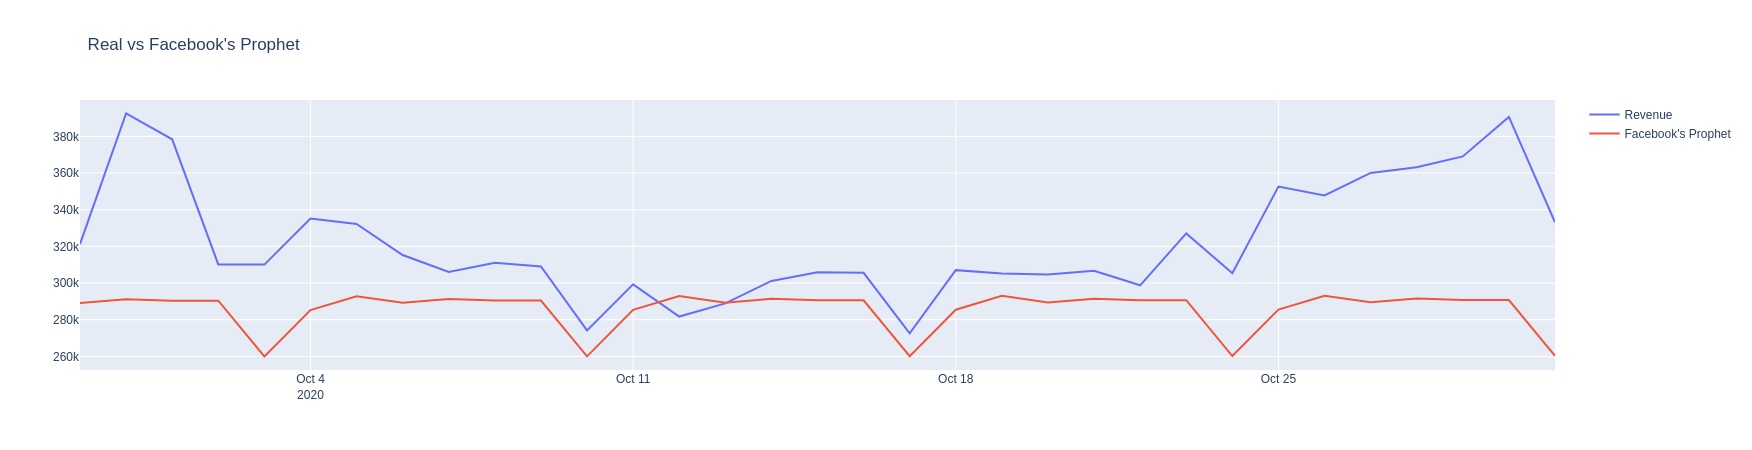

In [78]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=prophet_forecast["ds"].iloc[90:],y=prophet_forecast["yhat"].iloc[90:],name="Facebook's Prophet"))
fig.update_layout(title="Real vs Facebook's Prophet")
fig.show()

In [79]:
#Prophets includes their own evaluation diagnonstics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [80]:
#INTIAL
initial = str(30) + ' days'
#PERIOD
period = str(10) + ' days'
#HORIZON
horizon = str(5) + ' days'

In [81]:
fb_cv = cross_validation(fb_prophet_model,initial= initial, period=period,horizon=horizon)

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-08-04 00:00:00 and 2020-09-23 00:00:00


In [82]:
fb_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-08-05,348092.504694,317416.158977,380922.087749,298387.24,2020-08-04
1,2020-08-06,340417.709740,308702.464673,375043.930155,286876.16,2020-08-04
2,2020-08-07,341631.105777,306925.966479,373203.135832,288568.58,2020-08-04
3,2020-08-08,296243.017178,263550.203340,329548.249524,253175.06,2020-08-04
4,2020-08-09,335639.778339,301483.033621,367155.232411,277877.36,2020-08-04


In [83]:
performance_metrics(fb_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.540347e+09,39247.248522,36420.828952,0.130521,0.140205,0.333333
1,2 days,1.420269e+09,37686.456060,34472.561554,0.125240,0.108078,0.500000
2,3 days,1.812044e+09,42568.111292,36059.887890,0.128489,0.139582,0.500000
3,4 days,2.418562e+09,49178.882545,44598.386510,0.152139,0.162043,0.333333
4,5 days,2.787603e+09,52797.755594,48571.010222,0.168927,0.180007,0.166667


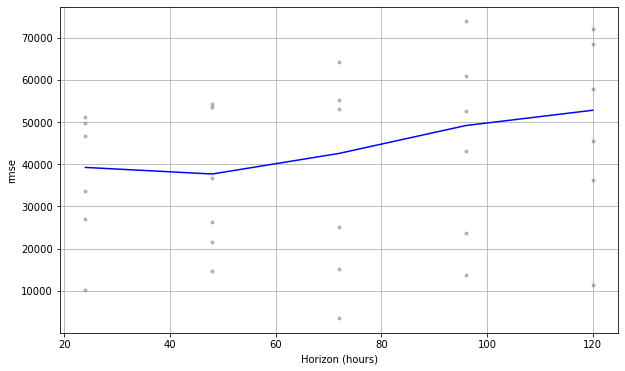

In [84]:
plot_cross_validation_metric(fb_cv,metric='rmse');

## Tensorflow Recurrent Neural Nets

Recurrents Neural Nets are useful for time series analysis because it can look back at the previous step and the current step before it makes it predictions. 

In [85]:
df_tf = df.copy()
df_tf.head()

,Revenue,week_day
Date,,
2020-07-01,310125.53,Wednesday
2020-07-02,267367.19,Thursday
2020-07-03,259462.99,Friday
2020-07-04,225009.43,Saturday
2020-07-05,256431.46,Sunday


In [102]:
#Create train and test split
tf_train = df_tf[['Revenue']].iloc[:90]
tf_test = df_tf[['Revenue']].iloc[90:]

In [103]:
#Scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [104]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

standard_train = standard_scaler.fit_transform(tf_train)
minmax_train = minmax_scaler.fit_transform(tf_train)

standard_test = standard_scaler.fit_transform(tf_test)
minmax_test = minmax_scaler.fit_transform(tf_test)

### Using a TimeseriesGenerator

In [105]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [106]:
n_inputs = 12
n_features = 1

timeseries_gen = TimeseriesGenerator(standard_train,standard_train,length=n_inputs,batch_size=1)

In [107]:
X, y = timeseries_gen[0]
X.shape

(1, 12, 1)

In [120]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.01):
            print("\nReached acceptable loss!")
            self.model.stop_training = True

In [115]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM

In [116]:
tf_model = Sequential()
tf_model.add(LSTM(600,activation='relu',input_shape=(n_inputs,n_features)))
tf_model.add(Dense(1))
tf_model.compile(optimizer='adam',loss='mse')

In [117]:
tf_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 600)               1444800   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 601       
Total params: 1,445,401
Trainable params: 1,445,401
Non-trainable params: 0
_________________________________________________________________


In [122]:
callback = myCallback()
tf_model.fit_generator(timeseries_gen,epochs=100,callbacks=[callback])

Epoch 1/100
78/78 [==============================] - 5s 67ms/step - loss: 0.6823
Epoch 2/100
78/78 [==============================] - 5s 59ms/step - loss: 0.5109
Epoch 3/100
78/78 [==============================] - 5s 62ms/step - loss: 0.5213
Epoch 4/100
78/78 [==============================] - 5s 69ms/step - loss: 0.4555
Epoch 5/100
78/78 [==============================] - 5s 67ms/step - loss: 0.5003
Epoch 6/100
78/78 [==============================] - 5s 69ms/step - loss: 0.4546
Epoch 7/100
78/78 [==============================] - 5s 62ms/step - loss: 0.4576
Epoch 8/100
78/78 [==============================] - 5s 60ms/step - loss: 0.5296
Epoch 9/100
78/78 [==============================] - 5s 60ms/step - loss: 0.5017
Epoch 10/100
78/78 [==============================] - 5s 58ms/step - loss: 0.4406
Epoch 11/100
78/78 [==============================] - 4s 57ms/step - loss: 0.4286
Epoch 12/100
78/78 [==============================] - 4s 56ms/step - loss: 0.3990
Epoch 13/100
78/78 [=====

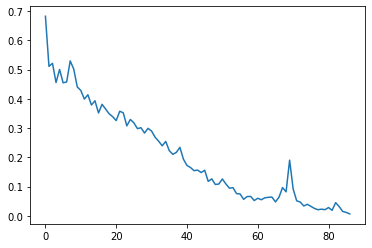

In [123]:
tf_loss = tf_model.history.history["loss"]
plt.plot(range(len(tf_loss)),tf_loss)

In [ ]:
#first_eval_batch = standard_train[-2:]

In [ ]:
#first_eval_batch = first_eval_batch.reshape(1,n_inputs,n_features)

In [ ]:
#tf_model.predict(first_eval_batch)

In [ ]:
#standard_train[-2:]

In [124]:
tf_timeseries_pred = []

first_eval_batch = standard_train[-n_inputs:]
current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

for i in range(len(standard_test)):
    
    current_pred = tf_model.predict(current_batch)[0]
    
    tf_timeseries_pred.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [125]:
tf_inverted_preds = standard_scaler.inverse_transform(tf_timeseries_pred)
tf_inverted_preds

array([[363114.88],
       [380602.47],
       [389844.4 ],
       [386538.2 ],
       [394337.97],
       [364218.75],
       [367484.06],
       [362799.6 ],
       [354220.78],
       [343259.78],
       [354992.06],
       [354037.7 ],
       [308968.53],
       [336279.06],
       [343611.84],
       [341160.12],
       [331632.4 ],
       [319351.97],
       [320097.66],
       [287322.22],
       [275053.94],
       [290483.03],
       [320463.88],
       [327552.7 ],
       [317632.84],
       [311961.3 ],
       [286842.6 ],
       [276215.03],
       [302288.97],
       [310748.75],
       [318838.6 ],
       [314952.8 ],
       [351459.34]], dtype=float32)

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




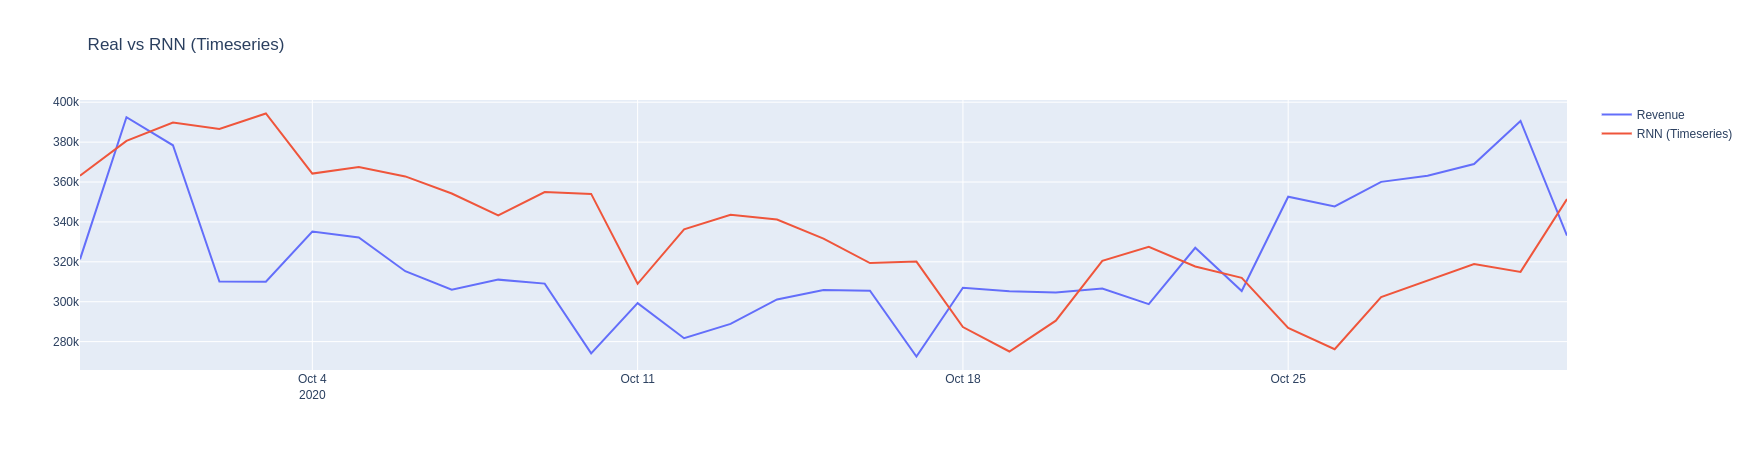

In [126]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=df_tf.index[90:],y=tf_inverted_preds.flatten(),name="RNN (Timeseries)"))
fig.update_layout(title="Real vs RNN (Timeseries)")
fig.show()

## Comparing Model Performance

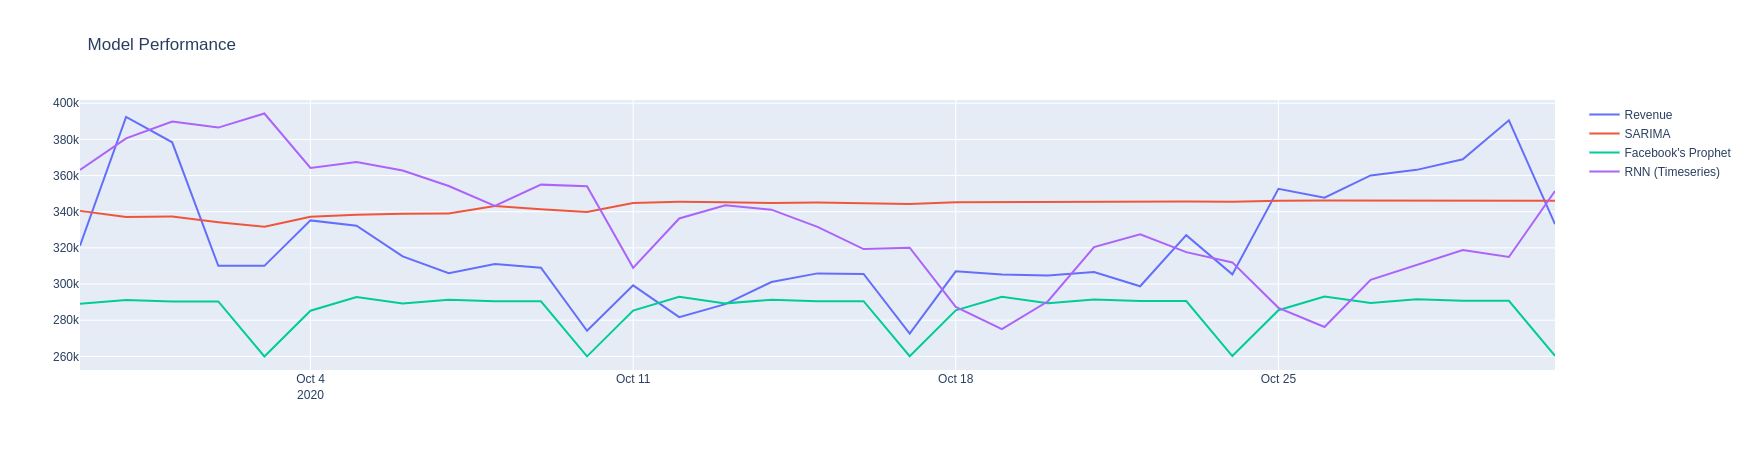

In [127]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=sarima_predictions.index,y=sarima_predictions,name="SARIMA"))
fig.add_trace(go.Line(x=prophet_forecast["ds"].iloc[90:],y=prophet_forecast["yhat"].iloc[90:],name="Facebook's Prophet"))
fig.add_trace(go.Line(x=df_tf.index[90:],y=tf_inverted_preds.flatten(),name="RNN (Timeseries)"))
fig.update_layout(title="Model Performance")
fig.show()

### MSE and RMSE for each model

In [128]:
from sklearn.metrics import mean_squared_error

In [129]:
real_values = df['Revenue'].iloc[90:]

mse_sarima = mean_squared_error(real_values,sarima_predictions)

In [130]:
mse_fb = mean_squared_error(real_values,prophet_forecast["yhat"].iloc[90:])

In [131]:
mse_rnn = mean_squared_error(real_values,tf_inverted_preds.flatten())

In [132]:
rmse_sarima = np.sqrt(mse_sarima)
rmse_fb = np.sqrt(mse_fb)
rmse_rnn = np.sqrt(mse_rnn)

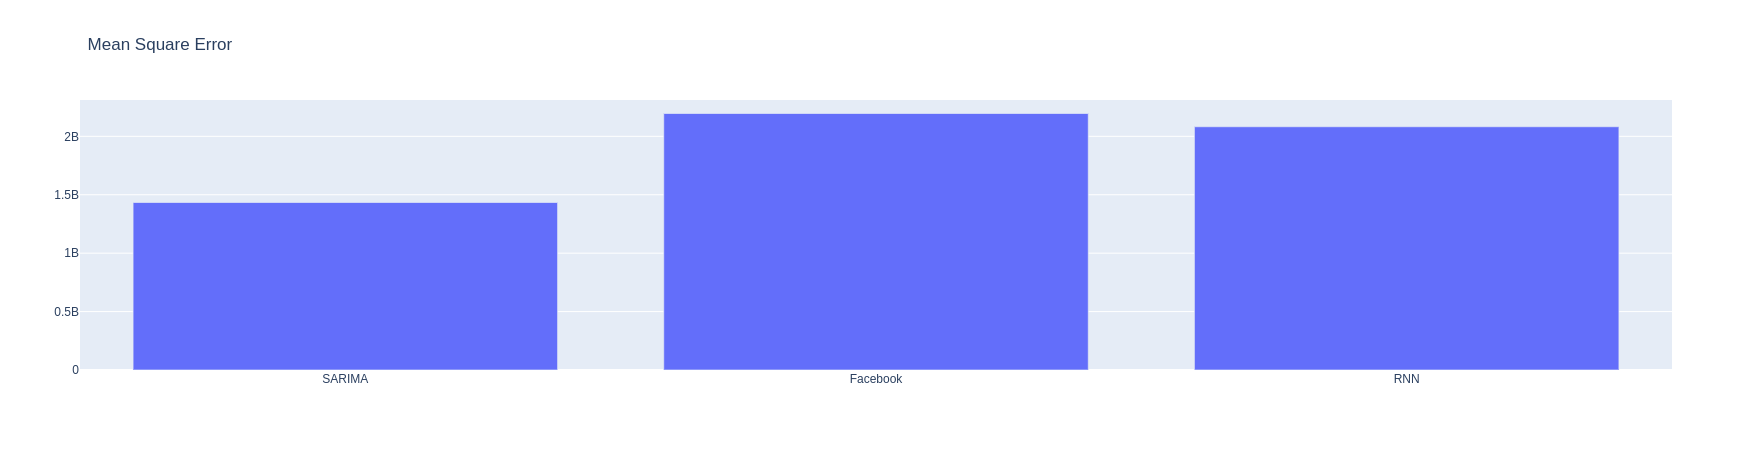

In [133]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Bar(x=["SARIMA","Facebook","RNN"],y=[mse_sarima,mse_fb,mse_rnn]))
fig.update_layout(title="Mean Square Error")
fig.show()

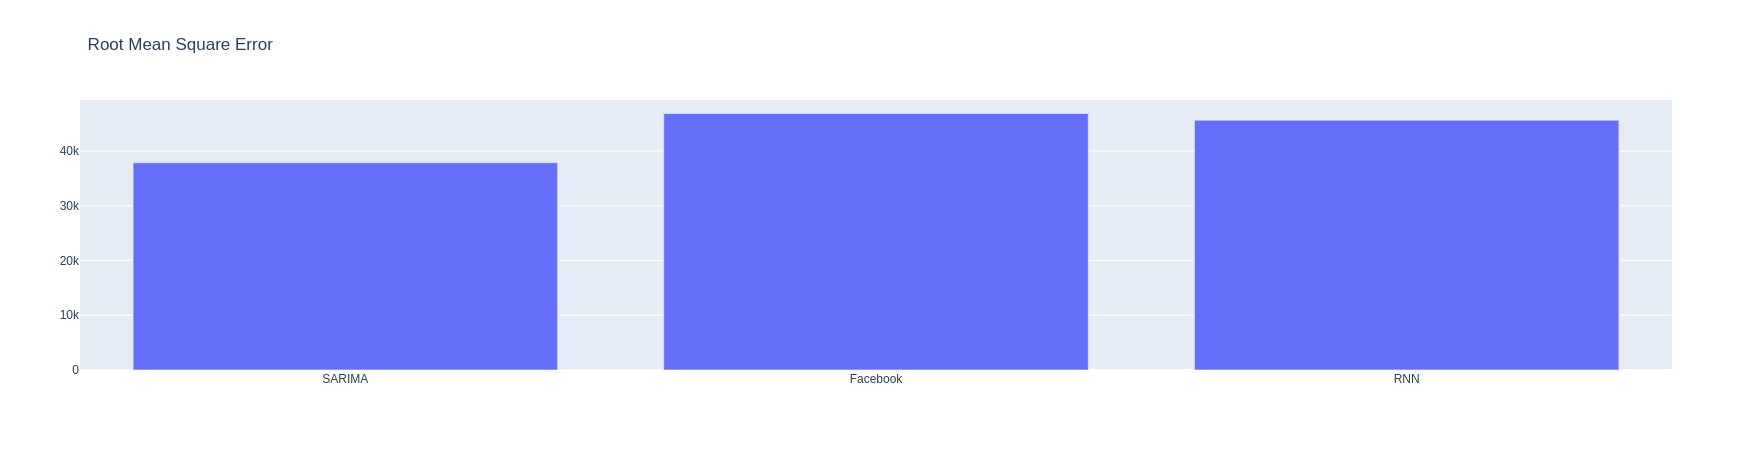

In [134]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Bar(x=["SARIMA","Facebook","RNN"],y=[rmse_sarima,rmse_fb,rmse_rnn]))
fig.update_layout(title="Root Mean Square Error")
fig.show()